In [1]:
import numpy as np
import pandas as pd
import sqlite3

from datetime import datetime

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import matplotlib.pyplot as plt

import tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesResampler
from tslearn.clustering import TimeSeriesKMeans, KShape, KernelKMeans

/Users/tihonvorobev/miniconda3/envs/ml/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
# читаем и смотрим на данные
con = sqlite3.connect('trade_info.sqlite3')
trading_session = pd.read_sql('SELECT * FROM Trading_session', con)
chart_data = pd.read_sql('SELECT * FROM Chart_data', con)
con.close()

In [3]:
trading_session.head()

,id,date,trading_type,platform_id
0,11,2019-10-04,daily,1
1,12,2019-10-03,daily,2
2,13,2019-10-01,daily,2
3,14,2019-10-15,monthly,1
4,15,2019-10-15,monthly,2


In [4]:
chart_data.head()

,id,time,lot_size,session_id,deal_id,price
0,0,11:34:47,2,12,0,-0.235500
1,1,11:32:37,2,13,1,-0.235500
2,2,11:52:45,13,13,2,-0.303677
3,3,11:53:07,25,13,3,-0.303677
4,4,12:00:43,124,13,4,-0.364279


In [5]:
con = sqlite3.connect('trade_info.sqlite3')
data =  pd.read_sql(
    """SELECT * FROM Chart_data C
    JOIN Trading_session T ON C.session_id=T.id
    WHERE T.trading_type = 'monthly'""",
    con)
con.close()

data['all_date'] = pd.to_datetime(data.date + " " + data.time)
data.sort_values(by='all_date', inplace=True)
data.drop_duplicates(subset='deal_id', inplace=True)

data.time = pd.to_datetime(data.time,  format="%H:%M:%S")
#торги идут только час
data.time = data.time.apply(lambda x: datetime(x.year, x.month, x.day, 0, x.minute, x.second))

# может быть есть годовая или месячная или недельная сезонность
data['year'] = data.all_date.apply(lambda x: x.date().year)
data['month'] = data.all_date.apply(lambda x: x.date().month)
data['week'] = data.all_date.apply(lambda x: x.weekday())
data['hour'] = data.all_date.apply(lambda x: x.hour)

data.drop(['id', 'deal_id', 'trading_type', 'date'], axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)

In [6]:
data.head()

,time,lot_size,session_id,price,platform_id,all_date,year,month,week,hour
0,1900-01-01 00:05:02,1,35,-0.735466,1,2019-02-21 11:05:02,2019,2,3,11
1,1900-01-01 00:05:02,1,36,-1.129379,2,2019-02-21 11:05:02,2019,2,3,11
2,1900-01-01 00:05:02,16,39,-0.765767,1,2019-03-22 11:05:02,2019,3,4,11
3,1900-01-01 00:05:02,4,39,-0.765767,1,2019-03-22 11:05:02,2019,3,4,11
4,1900-01-01 00:05:02,17,39,-0.765767,1,2019-03-22 11:05:02,2019,3,4,11


In [7]:
#time coding
data.week = np.sin(np.pi * data.week / 4)
data.month = np.sin(np.pi * (data.month - 1) / 11)

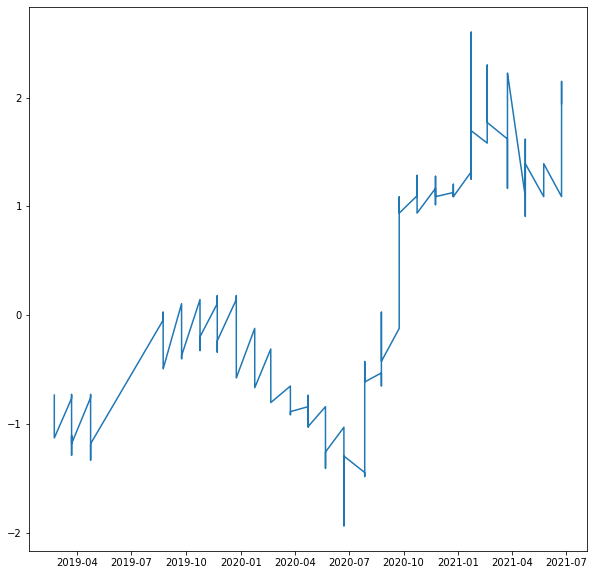

In [8]:
# сильно меняется тренд цен внутри сессий,
# не очень понятно
# хорошая ли идея вводить в качестве признака
# сессии среднюю цену
plt.figure(figsize = (10, 10))
plt.plot(data.all_date, data.price)

In [9]:
# по праздникам не торгуют
import holidays
ru_holidays = holidays.RU(years=range(2019, 2022))
data.all_date.apply(lambda x: x.date() in ru_holidays).sum()

0

In [10]:
# time_line = pd.date_range(datetime(1900, 1, 1, 11, 0, 0), datetime(1900, 1, 1, 13, 0, 0), 5)
# for start, end in zip(time_line, time_line[1:]):
#     data[np.logical_and(data.time >= start, data.time < end)]

In [11]:
session_groupby = data.groupby('session_id')

session_data = pd.DataFrame()
session_data['mean_price'] = session_groupby['price'].mean()
#session_data['min_price'] = session_groupby['price'].min()
#session_data['max_price'] = session_groupby['price'].max()
session_data['min_price_shift'] = session_data.mean_price -  session_groupby['price'].min()
session_data['max_price_shift'] = session_groupby['price'].max() - session_data.mean_price

session_data['lot_size'] = session_groupby['lot_size'].sum()

session_data['platform_id'] = session_groupby['platform_id'].median()
session_data['year'] = session_groupby['year'].median()
session_data['month'] = session_groupby['month'].median()
session_data['week'] = session_groupby['week'].median()
session_data['start_hour'] = session_groupby['hour'].min()

session_data['transactions'] = session_groupby.size()

session_data.head()

,mean_price,min_price_shift,max_price_shift,lot_size,platform_id,year,month,week,start_hour,transactions
session_id,,,,,,,,,,
27,0.059151,0.067394,0.084111,2134,1.0,2019.0,0.540641,0.707107,11,58
28,-0.266736,0.059667,0.220617,3284,2.0,2019.0,0.540641,0.707107,12,81
29,-0.346423,0.055732,0.110923,4288,2.0,2019.0,0.755750,0.000000,12,126
30,0.035852,0.074396,0.069534,3177,1.0,2019.0,0.755750,0.000000,11,67
35,-0.735466,0.000000,0.000000,1,1.0,2019.0,0.281733,0.707107,11,1


In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler_session_data = scaler.fit_transform(session_data)
scaler_session_data = pd.DataFrame(scaler_session_data, index=session_data.index, columns=session_data.columns)
scaler_session_data.head()

,mean_price,min_price_shift,max_price_shift,lot_size,platform_id,year,month,week,start_hour,transactions
session_id,,,,,,,,,,
27,-0.043662,-0.453305,-0.556474,-0.734170,-1.0,-1.264911,-0.051089,0.814786,-0.925820,0.012857
28,-0.350541,-0.512051,0.165024,-0.190711,1.0,-1.264911,-0.051089,0.814786,1.080123,0.711800
29,-0.425580,-0.541965,-0.414760,0.283753,1.0,-1.264911,0.595446,-0.901506,1.080123,2.079297
30,-0.065602,-0.400070,-0.633522,-0.241276,-1.0,-1.264911,0.595446,-0.901506,-0.925820,0.286356
35,-0.791932,-0.965686,-1.001041,-1.742169,-1.0,-1.264911,-0.829270,0.814786,-0.925820,-1.719306


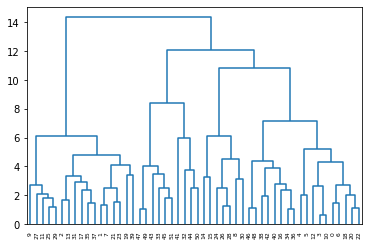

In [13]:
# с косинусным вышло хуже
link = linkage(scaler_session_data, 'ward', 'euclidean')
dn = dendrogram(link, color_threshold = -1)

In [14]:
s_data = session_data.copy()
s_data.week = 4 * np.arcsin(s_data.week) / np.pi
s_data.month = 11 * np.arcsin(s_data.month) / np.pi + 1

s_data['cluster'] = fcluster(link, 8, criterion='distance')
s_data.groupby('cluster').mean()

,mean_price,min_price_shift,max_price_shift,lot_size,platform_id,year,month,week,start_hour,transactions
cluster,,,,,,,,,,
1,-0.444970,0.083291,0.133718,4960.882353,2.000000,2019.647059,3.470588,0.411765,12.00,88.411765
2,1.670815,0.090780,0.101126,1008.500000,2.000000,2020.833333,4.000000,1.166667,12.00,28.500000
3,1.150126,0.230400,0.631284,2610.750000,1.250000,2020.750000,3.500000,1.500000,11.25,31.750000
4,-0.748049,0.361851,0.371866,5774.714286,1.142857,2019.571429,3.857143,0.285714,11.00,73.142857
5,0.203466,0.066095,0.102244,2805.611111,1.055556,2019.833333,2.777778,0.555556,11.00,37.833333


Сессии из первых двух класетров торгуют только на второй платформе с 12 часов.

Остальные сессии из последних трех кластереров преимущественно находятся на первой платформе и начинают торги в 11.

1, 2 и 5 клатер можно назвать безопасными, цены не сильно колеблятся, но количество транзакций и их размеры меньше.

3, 4 кластер наверное соответсвуют опасным играм, так как цены сильно изменяются в течении часа, много транзакций и много закупают.

1 и 5 наверное соответсвуют закупочным сессиям на разных платформах, так как в него попало много сессий, цены не сильно меняются, но много транзакций и большое количество закупок.

In [15]:
s_data.groupby('cluster').size()

cluster
1    17
2     6
3     4
4     7
5    18
dtype: int64

Рассмотрим кластеризацию сессий, которая учитывает то, что они являются временными рядами

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def plot_session(data):
    plt.figure(figsize = (10, 10))
    for session_id in data.session_id.unique():
        cur_session = data[data.session_id == session_id]

        plt.plot(
            cur_session.all_date.apply(lambda x: datetime(1900, 1, 1, 0, x.minute, x.second)),
            cur_session.norm_price,
            label=f"Session: {session_id}"
        )

        plt.xlabel("Time")
        plt.ylabel("Norm price")

    plt.legend()
    plt.show()

In [17]:
con = sqlite3.connect('trade_info.sqlite3')
data =  pd.read_sql(
    """SELECT * FROM Chart_data C
    JOIN Trading_session T ON C.session_id=T.id
    WHERE T.trading_type = 'monthly'""",
    con)
con.close()

data['all_date'] = pd.to_datetime(data.date + " " + data.time)
data.sort_values(by='all_date', inplace=True)
data.drop_duplicates(subset='deal_id', inplace=True)

#торги идут только час
data.all_date = data.all_date.apply(lambda x: datetime(x.year, x.month, x.day, 0, x.minute, x.second))

data.drop(['id', 'deal_id', 'trading_type', 'lot_size', 'time', 'date'], axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)

In [18]:
# будем нормировать цену внутри сессии
value_counts = data.session_id.value_counts()
data = data[data.session_id.isin(value_counts[value_counts >= 30].index)]
data['norm_price'] = data.groupby("session_id")["price"].transform(lambda x: (x - x.mean()) / x.std())
data.drop(['price'], axis=1, inplace=True)

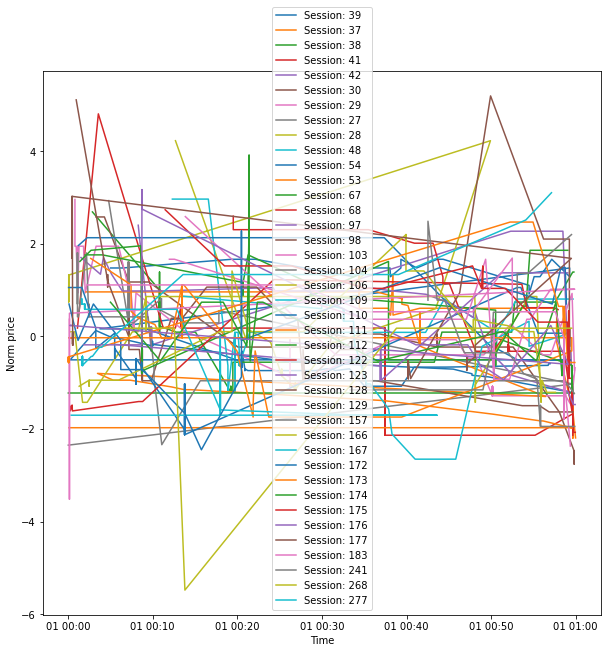

In [19]:
plot_session(data)

In [20]:
time_series_dataset = []
for _, values in data.groupby('session_id')['norm_price']:
    if values.shape[0] > 1:
        time_series_dataset.append(values.tolist())

time_series_dataset = to_time_series_dataset(time_series_dataset)
time_series_dataset = TimeSeriesResampler(sz=time_series_dataset.shape[1]).fit_transform(time_series_dataset)

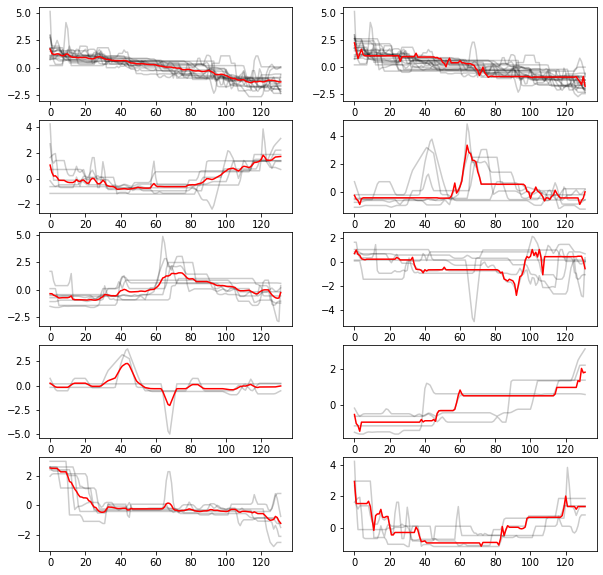

In [21]:
#рассмотрим также 5 кластеров
n_clusters = 5
n_init = 10

model_1 = TimeSeriesKMeans(n_clusters=n_clusters, metric='euclidean', n_init=n_init)
model_2 = TimeSeriesKMeans(n_clusters=n_clusters, metric='dtw', n_init=n_init)
models = [model_1, model_2]

y_pred_1 = model_1.fit_predict(time_series_dataset)
y_pred_2 = model_2.fit_predict(time_series_dataset)
y_preds = [y_pred_1, y_pred_2]

plt.figure(figsize = (10, 10))
for i in range(n_clusters):
    for j in range(2):
        plt.subplot(n_clusters, 2, 2 * i + j + 1)
        for time_series in time_series_dataset[y_preds[j] == i]:
            plt.plot(time_series.ravel(), "k-", alpha=0.2)
        plt.plot(models[j].cluster_centers_[i].ravel(), "r-")
plt.show()

In [22]:
# хотим чтобы сессии содержали одинаковое количество точек
# разобьем на бины и сгладим
unique_session_id = data.session_id.unique()
unique_session_id = np.hstack([unique_session_id[0], unique_session_id, unique_session_id[-1]])
mean_norm_price = data.groupby('session_id')['norm_price'].mean()

for prev_session_id, session_id, next_session_id in zip(unique_session_id, unique_session_id[1:], unique_session_id[2:]):
    cur_session = data[data.session_id == session_id].iloc[0]
    platform_id = cur_session.platform_id
    date = cur_session.all_date
    data = pd.concat([
        data,
        pd.DataFrame({
            'session_id': session_id,
            'platform_id': platform_id,
            'all_date': [
                datetime(date.year, date.month, date.day, 0, 0, 0),
                datetime(date.year, date.month, date.day, 0, 59, 0)
            ],
            #берем среднее до нас и среднее после нас
            'norm_price': [
                mean_norm_price[mean_norm_price.index == prev_session_id].iloc[0],
                mean_norm_price[mean_norm_price.index == next_session_id].iloc[0]
            ]
        })
    ])

data = data.groupby('session_id').resample("1T", on="all_date").mean().interpolate("linear")
data.drop('session_id', axis=1, inplace=True)
data.reset_index(inplace=True)

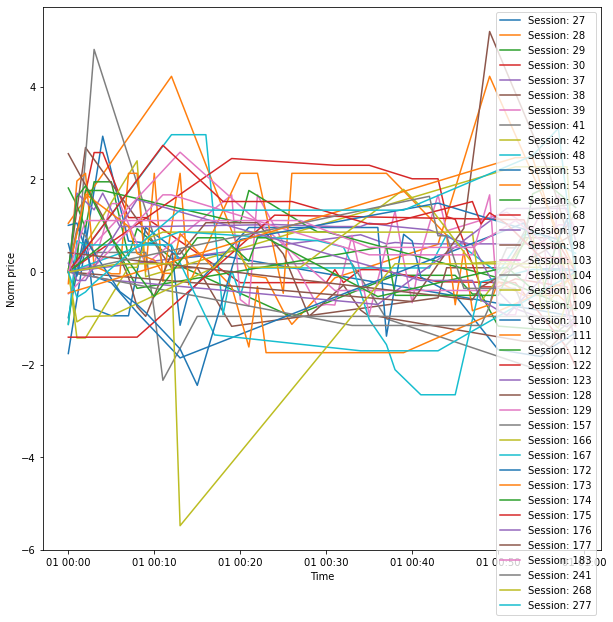

In [23]:
plot_session(data)

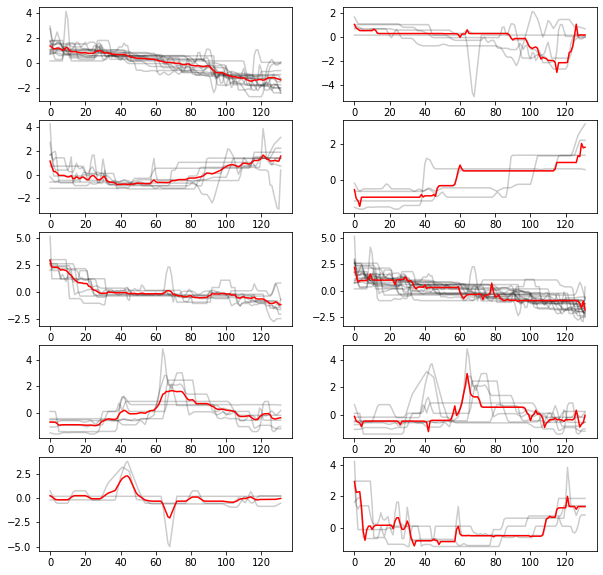

In [24]:
n_clusters = 5
n_init = 10

model_1 = TimeSeriesKMeans(n_clusters=n_clusters, metric='euclidean', n_init=n_init)
model_2 = TimeSeriesKMeans(n_clusters=n_clusters, metric='dtw', n_init=n_init)
models = [model_1, model_2]

y_pred_1 = model_1.fit_predict(time_series_dataset)
y_pred_2 = model_2.fit_predict(time_series_dataset)
y_preds = [y_pred_1, y_pred_2]

plt.figure(figsize = (10, 10))
for i in range(n_clusters):
    for j in range(2):
        plt.subplot(n_clusters, 2, 2 * i + j + 1)
        for time_series in time_series_dataset[y_preds[j] == i]:
            plt.plot(time_series.ravel(), "k-", alpha=0.2)
        plt.plot(models[j].cluster_centers_[i].ravel(), "r-")
plt.show()